# Modelling - Logistic Regression and others

In this section we will model our data and try to predict the passenger sentiment, based on if they would recomend the flight.

1. Load Data
2. Clean up each table
3. Create dummy variables
4. Combine different types of data together to create different sets of features
5. Test different combinatins of features based on their ability to predict if someone would recommend the flight
6. Tune Hyperparameters, and test the RandomForest() algorythm
7. Graph coefficients to extract useful insights 


In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from itertools import combinations

In [2]:
# Load Data
LDA_Topics_df = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/LDA_Topics.csv')
BERTopic_df = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/bert_output.csv')
gpt_results_df = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/gpt_final.csv')
airline = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/airline_reviews_cleaned.csv')

In [3]:
# Drop unnecessary columns
columns_to_drop = ['airline', 'home_country', 'customer_review', 'review_word_count',
       'cabin', 'date_flown', 'days_between_flight_and_review', 'overall',
       'recommended', 'seat_comfort', 'cabin_service', 'food_bev',
       'entertainment', 'ground_service', 'value_for_money',
       'seat comfort_pos', 'seat comfort_neg', 'cabin service_pos',
       'cabin service_neg', 'food and beverage_pos', 'food and beverage_neg',
       'entertainment_pos', 'entertainment_neg', 'ground service_pos',
       'ground service_neg', 'value for money_pos', 'value for money_neg',
       'Dominant_Topic']

BERTopic_df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# Create dummy variables for BERTopic
BERTopic_df = pd.get_dummies(BERTopic_df, columns=['BERTopic'])


In [5]:
#Drop redundant columns
gpt_results_df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Drop unnecessary columns
airline.drop(columns=['airline',
                      'date_flown', 
                      'overall', 
                      'seat_comfort', 
                      'cabin_service', 
                      'food_bev', 
                      'entertainment', 
                      'ground_service', 
                      'value_for_money', 
                      'days_between_flight_and_review'], 
             inplace=True)


In [7]:
# Create a simple airline dataframe to test minimum number of features
airline_simple = airline.copy()
airline_simple.drop(columns=['customer_review', 'home_country'], inplace=True)
airline_simple = pd.get_dummies(airline, columns=['cabin'])

In [8]:
# Drop columns
airline_simple.drop(columns=['customer_review', 'home_country'], inplace=True)

In [9]:
# Create dummy variables for home country and cabin
airline = pd.get_dummies(airline, columns=['home_country','cabin'])

In [10]:
# Initialize the MinMaxScaler to scale between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the columns to scale
columns_to_scale = ['review_word_count']


# Scale data
scaled_values = scaler.fit_transform(airline[columns_to_scale])

# Assign the scaled values back to the DataFrame
airline[columns_to_scale] = scaled_values


In [11]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=250)  # Adjust ngram_range and max_features as needed

# Fit and transform the 'customer_review' column
tfidf_matrix = tfidf_vectorizer.fit_transform(airline['customer_review'])

# Get the feature names (unigrams and bigrams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with flags indicating the presence of features
feature_flags = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Concatenate the flags DataFrame with the original data
airline_vec_text = pd.concat([airline, feature_flags], axis=1)

### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

The TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a technique used in natural language processing (NLP) and information retrieval to convert textual data into a numerical format, making it easier for algorithms to process. It reflects how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [12]:
# Drop the 'customer_review' column
airline.drop(columns=['customer_review'], inplace=True)
airline_vec_text.drop(columns=['customer_review'], inplace=True)

Below is a check on each DataFrame

In [13]:
airline_simple

,review_word_count,recommended,cabin_Business Class,cabin_Economy Class,cabin_First Class,cabin_Premium Economy
0,204,1,False,True,False,False
1,85,0,False,True,False,False
2,297,0,False,True,False,False
3,158,1,False,True,False,False
4,73,0,False,True,False,False
...,...,...,...,...,...,...
59386,75,0,False,True,False,False
59387,65,0,False,True,False,False
59388,63,0,False,True,False,False
59389,41,0,False,True,False,False


In [14]:
LDA_Topics_df

,Dominant_Topic
0,0
1,1
2,0
3,0
4,1
...,...
59386,0
59387,0
59388,0
59389,0


In [15]:
BERTopic_df

,BERTopic_-1,BERTopic_0,BERTopic_1,BERTopic_2,BERTopic_3,BERTopic_4,BERTopic_5,BERTopic_6,BERTopic_7,BERTopic_8,...,BERTopic_206,BERTopic_207,BERTopic_208,BERTopic_209,BERTopic_210,BERTopic_211,BERTopic_212,BERTopic_213,BERTopic_214,BERTopic_215
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17495,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17496,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17497,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17498,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
gpt_results_df

,seat comfort_pos,seat comfort_neg,cabin service_pos,cabin service_neg,food and beverage_pos,food and beverage_neg,entertainment_pos,entertainment_neg,ground service_pos,ground service_neg,value for money_pos,value for money_neg
0,1,0,1,0,1,0,1,0,0,1,0,1
1,0,1,0,1,0,1,0,1,0,1,0,1
2,0,1,1,0,0,1,0,1,0,1,0,1
3,1,0,1,0,1,0,1,0,1,0,1,0
4,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
59386,1,0,1,0,1,0,1,0,1,0,1,0
59387,0,0,1,0,0,1,0,0,0,0,0,1
59388,0,0,1,0,0,1,0,0,1,0,0,0
59389,1,0,1,0,1,0,1,0,1,0,1,0


In [17]:
airline

,review_word_count,recommended,home_country_Australia,home_country_Austria,home_country_Bahrain,home_country_Belgium,home_country_Canada,home_country_Chile,home_country_China,home_country_Colombia,...,home_country_Tunisia,home_country_Turkey,home_country_Ukraine,home_country_United Arab Emirates,home_country_United Kingdom,home_country_United States,cabin_Business Class,cabin_Economy Class,cabin_First Class,cabin_Premium Economy
0,0.203407,1,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,0.084168,0,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,0.296593,0,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,0.157315,1,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,0.072144,0,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59386,0.074148,0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
59387,0.064128,0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
59388,0.062124,0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
59389,0.040080,0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [18]:
airline_vec_text

,review_word_count,recommended,home_country_Australia,home_country_Austria,home_country_Bahrain,home_country_Belgium,home_country_Canada,home_country_Chile,home_country_China,home_country_Colombia,...,with the,with them,with this,would be,would have,would not,you are,you can,you have,âœ verified
0,0.203407,1,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.084168,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.247957,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.296593,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.160699,0.0,0.000000,0.0,0.311169,0.0,0.0,0.0
3,0.157315,1,False,False,False,False,False,False,False,False,...,0.130916,0.160996,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.072144,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.519437,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59386,0.074148,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.292251,0.0,0.000000,0.0,0.0,0.0
59387,0.064128,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
59388,0.062124,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.645476,0.0,0.0,0.0
59389,0.040080,0,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


# Testing Multiple DataFrames

We now construct 15 DataFrames by joining existing data in different ways. 

The goal is to see what will have the most predictive power, while trying to minimize the number of features, and maximize the explainability - so the end used can take away useful insights.

In [19]:
df_BERT_LLM_LDA_VecText =   airline_vec_text.join(gpt_results_df, how='inner')\
                            .join(BERTopic_df, how='inner')\
                            .join(LDA_Topics_df, how='inner')



In [20]:
df_BERT_LLM_VecText =   airline_vec_text.join(gpt_results_df, how='inner')\
                            .join(BERTopic_df, how='inner')

In [21]:
df_BERT_LDA_VecText =   airline_vec_text.join(BERTopic_df, how='inner')\
                            .join(LDA_Topics_df, how='inner')

In [22]:
df_LLM_LDA_VecText =   airline_vec_text.join(gpt_results_df, how='inner')\
                            .join(LDA_Topics_df, how='inner')

In [23]:
df_LDA_VecText =   airline_vec_text.join(LDA_Topics_df, how='inner')

In [24]:
df_LLM_VecText =   airline_vec_text.join(gpt_results_df, how='inner')

In [25]:
df_BERT_VecText =   airline_vec_text.join(BERTopic_df, how='inner')

In [26]:
df_BERT_LLM_LDA =   airline.join(gpt_results_df, how='inner')\
                            .join(BERTopic_df, how='inner')\
                            .join(LDA_Topics_df, how='inner')



In [27]:
df_BERT_LDA =   airline.join(BERTopic_df, how='inner')\
                            .join(LDA_Topics_df, how='inner')

In [28]:
df_BERT_LLM = airline.join(gpt_results_df, how='inner')\
                            .join(BERTopic_df, how='inner')

In [29]:
df_LLM_LDA = airline.join(gpt_results_df, how='inner')\
                           .join(LDA_Topics_df, how='inner')

In [30]:
df_LDA = airline.join(LDA_Topics_df, how='inner')

In [31]:
df_LLM =  airline.join(gpt_results_df, how='inner')

In [32]:
df_LLM_only = airline_simple.join(gpt_results_df, how='inner')

In [33]:
df_BERT =   airline.join(BERTopic_df, how='inner')

In [34]:
# Creat a dictionary of DataFrames
dfs = {
    f'LLM_BERT_LDA_tfidfVec - {df_BERT_LLM_LDA_VecText.shape[1]} features': df_BERT_LLM_LDA_VecText,
    f'LLM_BERT_tfidfVec - {df_BERT_LLM_VecText.shape[1]} features': df_BERT_LLM_VecText,
    f'BERT_LDA_tfidfVec - {df_BERT_LDA_VecText.shape[1]} features': df_BERT_LDA_VecText,
    f'LLM_LDA_tfidfVec - {df_LLM_LDA_VecText.shape[1]} features': df_LLM_LDA_VecText,
    f'LDA_tfidfVec - {df_LDA_VecText.shape[1]} features': df_LDA_VecText,
    f'LLM_tfidfVec - {df_LLM_VecText.shape[1]} features': df_LLM_VecText,
    f'BERT_tfidfVec - {df_BERT_VecText.shape[1]} features': df_BERT_VecText,
    f'LL_BERT_LDA - {df_BERT_LLM_LDA.shape[1]} features': df_BERT_LLM_LDA,
    f'BERT_LDA - {df_BERT_LDA.shape[1]} features': df_BERT_LDA,
    f'LLM_BERT - {df_BERT_LLM.shape[1]} features': df_BERT_LLM,
    f'LLM_LDA - {df_LLM_LDA.shape[1]} features': df_LLM_LDA,
    f'LDA - {df_LDA.shape[1]} features': df_LDA,
    f'BERT - {df_BERT.shape[1]} features': df_BERT,
    f'LLM - {df_LLM_only.shape[1]} features': df_LLM_only
}

# Initialize placeholders
accuracy_records = []  # Use a list to store accuracy records
models = {}  # Dictionary to store models

# Loop through each DataFrame
for name, df in dfs.items():
    if 'recommended' in df.columns:
        X = df.drop(['recommended'], axis=1)
        y = df['recommended']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Initialize and train the logistic regression model
        model = LogisticRegression(max_iter=1500)
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results using a list of dicts (to avoid AttributeError)
        accuracy_records.append({'DataFrame': name, 'Accuracy': accuracy})
        models[name] = model

# Convert the list of dicts to a DataFrame
accuracy_df = pd.DataFrame(accuracy_records)

# Display accuracies
print(accuracy_df)

                               DataFrame  Accuracy
0   LLM_BERT_LDA_tfidfVec - 534 features  0.919238
1       LLM_BERT_tfidfVec - 533 features  0.918095
2       BERT_LDA_tfidfVec - 522 features  0.841143
3        LLM_LDA_tfidfVec - 322 features  0.917275
4            LDA_tfidfVec - 310 features  0.833483
5            LLM_tfidfVec - 321 features  0.914132
6           BERT_tfidfVec - 521 features  0.823048
7             LL_BERT_LDA - 284 features  0.914667
8                BERT_LDA - 272 features  0.772000
9                LLM_BERT - 283 features  0.916190
10                 LLM_LDA - 72 features  0.911775
11                     LDA - 60 features  0.755921
12                   BERT - 271 features  0.685714
13                     LLM - 18 features  0.908856


In [35]:
summarized_accuracy_df = accuracy_df.iloc[[0, 2, 13]]
summarized_accuracy_df

,DataFrame,Accuracy
0,LLM_BERT_LDA_tfidfVec - 534 features,0.919238
2,BERT_LDA_tfidfVec - 522 features,0.841143
13,LLM - 18 features,0.908856


In [36]:
# Assign new values to the 'DataFrame' column for specified rows
summarized_accuracy_df.at[0, 'DataFrame'] = 'LLM_BERT_LDA_WordEmbedding'
summarized_accuracy_df.at[2, 'DataFrame'] = 'BERT_LDA_WordEmbedding'
summarized_accuracy_df.at[13, 'DataFrame'] = 'LLM'


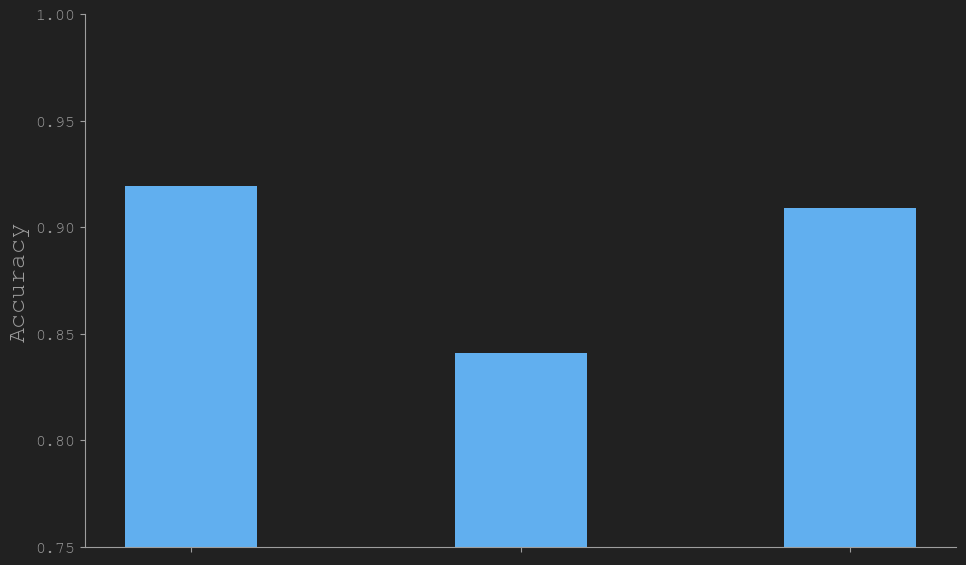

In [37]:
# Set global font settings for the plot
plt.rcParams.update({'font.size': 18, 'text.color': '#9e9e9e', 'font.family': 'Courier New'})

# Create a bar chart with narrower bars
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(summarized_accuracy_df['DataFrame'], summarized_accuracy_df['Accuracy'], color='#61afef', width=0.4)  # Adjust width as needed
plt.ylabel('Accuracy', fontsize=18, color='#9e9e9e')  # Y-axis label
plt.ylim([0.75, 1.0])  # Start Y-axis at 0.65

# Set the background color
plt.gca().set_facecolor('#212121')  # Set the background color of the axes
plt.gcf().set_facecolor('#212121')  # Set the background color of the figure

# Adjust tick colors and remove X-axis labels
plt.tick_params(axis='x', colors='#9e9e9e', labelsize=12, labelbottom=False)  # Remove X-axis labels
plt.tick_params(axis='y', colors='#9e9e9e', labelsize=12)  # Adjust Y-axis ticks

# Remove the box (spines) around the bar plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)  # Keeping the bottom spine for reference
plt.gca().spines['left'].set_visible(True)  # Keeping the left spine for reference

# Change the colors of the spines
plt.gca().spines['bottom'].set_color('#9e9e9e')
plt.gca().spines['left'].set_color('#9e9e9e')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping

# Show the plot
plt.show()


### Modeling Data
You can see that the larges DataFrame was the most effective, but it's only a ~1% increase in accuracy from the most simple data set 'LLM_only', which are the 12 LLM generated data points, along with what type of cabin, and the length of review. 

It's also worth noting that adding the synthetic LLM data increased the accuracy by ~7%. 

## Testing Hyperparameters and RandomForest()

Below we test hyperparameters and a RandomForest model. No major accuracy gains, although the tuned RandomForest model performed best, I prefer the Logistic Regresion Model due to it's explainability. 

In [38]:
# Split the data into features and target (if available)
X = df_LLM_only.drop(['recommended'], axis=1)  
y = df_LLM_only['recommended']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Norms used for regularization
    'solver': ['liblinear']  # Solver that supports penalty='l1'
}

# Initialize a LogisticRegression model
log_reg = LogisticRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy):", grid_search.best_score_)

# Optional: Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score (accuracy): 0.9102783892183686
Test set accuracy: 0.9088562128184982


In [39]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the evaluation results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      9254
           1       0.92      0.88      0.90      8564

    accuracy                           0.91     17818
   macro avg       0.91      0.91      0.91     17818
weighted avg       0.91      0.91      0.91     17818



### Classification Report
While the accuracy between the simple model and the model that rely on more features are similar, the F1 score is higher in models using more features. Given the low stakes of this data, and room for improved prompt engineering, I think is is acceptable. 

In [40]:

# Split the data into features and target (if available)
X = df_BERT_LLM_LDA_VecText.drop(['recommended'], axis=1)  
y = df_BERT_LLM_LDA_VecText['recommended']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'C': [1],  # Regularization strength
    'penalty': ['l2'],  # Norms used for regularization
    'solver': ['liblinear']  # Solver that supports penalty='l1'
}

# Initialize a LogisticRegression model
log_reg = LogisticRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy):", grid_search.best_score_)

# Optional: Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score (accuracy): 0.9177959183673469
Test set accuracy: 0.9192380952380952


In [41]:
# Split the data into features and target
X = df_LLM_only.drop(['recommended'], axis=1)
y = df_LLM_only['recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Simplified parameter grid
param_grid = {
    'n_estimators': [350,400, 450],  # Reduced for simplicity
    'max_depth': [15],  # Reduced for simplicity
    'min_samples_split': [40,50,60],  # Reduced for simplicity
}

# Initialize a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object with n_jobs=-1 to use all cores
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)




# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy):", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [ ]:
# Split the data into features and target
X = df_BERT_LLM_LDA_VecText.drop(['recommended'], axis=1)
y = df_BERT_LLM_LDA_VecText['recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Simplified parameter grid
param_grid = {
    'n_estimators': [450],  # Reduced for simplicity
    'max_depth': [15],  # Reduced for simplicity
    'min_samples_split': [50],  # Reduced for simplicity
}

# Initialize a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object with n_jobs=-1 to use all cores
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)




# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy):", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 50, 'n_estimators': 450}
Best cross-validation score (accuracy): 0.9224489795918366
Test set accuracy: 0.923047619047619


## Logistic Regression Model

Due to its explainability we will use the Logistic Regression Model for our final analysis. 

Below we run the model with the lowest number of features possible while using the LLM. We then run the model with the largest number of features.

We graph out the top 20 most impacty (10 positive / 10 negative). 

It's clear that the results are much more explainable, and useful, with the smaller number of features.

In [ ]:
# Split the data into features and target
X = df_LLM_only.drop(['recommended'], axis=1)
y = df_LLM_only['recommended']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a LogisticRegression model with specified parameters
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear')

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.91


In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the evaluation results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      9254
           1       0.92      0.88      0.90      8564

    accuracy                           0.91     17818
   macro avg       0.91      0.91      0.91     17818
weighted avg       0.91      0.91      0.91     17818



In [ ]:
feature_names = X.columns.tolist()

# Extract the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
coef_table = pd.DataFrame({'Variable': feature_names, 'Coefficient': coefficients})

# Display the table (optional)
print(coef_table)


                 Variable  Coefficient
0       review_word_count    -0.003132
1    cabin_Business Class     0.214534
2     cabin_Economy Class    -0.368412
3       cabin_First Class     0.084900
4   cabin_Premium Economy    -0.081933
5        seat comfort_pos     1.017389
6        seat comfort_neg    -0.872510
7       cabin service_pos     2.081523
8       cabin service_neg    -0.379541
9   food and beverage_pos     0.800381
10  food and beverage_neg    -0.089990
11      entertainment_pos     0.733969
12      entertainment_neg    -0.137866
13     ground service_pos     1.000945
14     ground service_neg    -1.117470
15    value for money_pos     1.878916
16    value for money_neg    -0.890779


In [ ]:
coef_table['Variable'] = coef_table['Variable'].str.replace('_pos', ': positive')
coef_table['Variable'] = coef_table['Variable'].str.replace('_neg', ': negative')


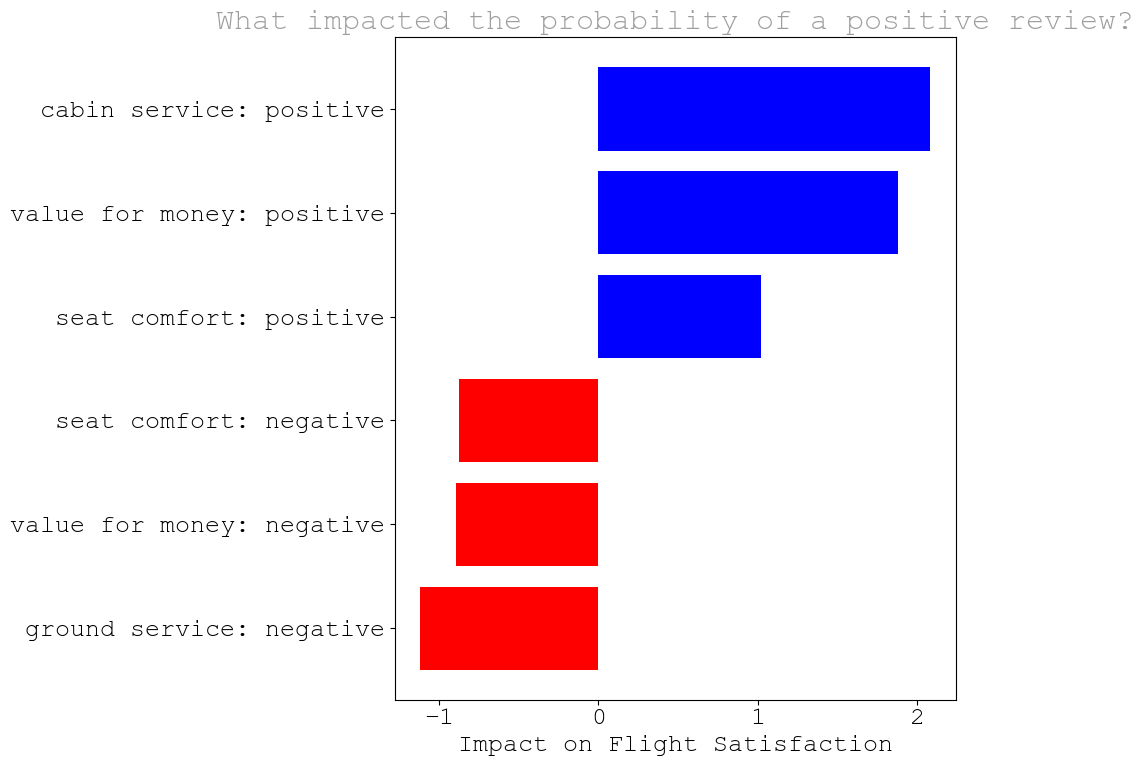

In [ ]:
# Separate positive and negative coefficients
positive_coef = coef_table[coef_table['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(3)
negative_coef = coef_table[coef_table['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(3)

# Combine them back
top_coef = pd.concat([negative_coef, positive_coef]).sort_values(by='Coefficient', ascending=True)

# Create colors array for the selected coefficients: red for negative, blue for positive
colors = ['red' if x < 0 else 'blue' for x in top_coef['Coefficient']]

# Plotting
plt.figure(figsize=(10, 8))  # Set figure size
plt.barh(top_coef['Variable'], top_coef['Coefficient'], color=colors)
plt.xlabel('Impact on Flight Satisfaction')
plt.title('What impacted the probability of a positive review?')

# Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

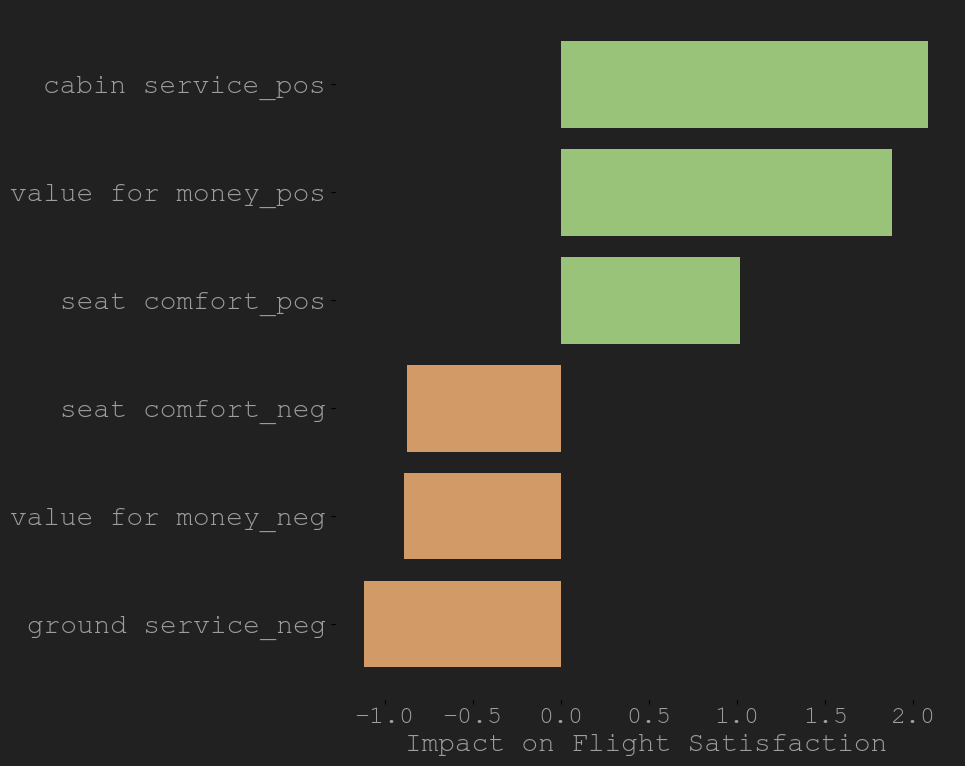

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Set global font to Courier New
plt.rcParams.update({'font.family': 'Courier New'})

# Assuming coef_table is your DataFrame containing the 'Coefficient' and 'Variable' columns

# Separate positive and negative coefficients
positive_coef = coef_table[coef_table['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(3)
negative_coef = coef_table[coef_table['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(3)

# Combine them back
top_coef = pd.concat([negative_coef, positive_coef]).sort_values(by='Coefficient', ascending=True)

# Create colors array for the selected coefficients: #d19a66 for negative, #98C379 for positive
colors = ['#d19a66' if x < 0 else '#98C379' for x in top_coef['Coefficient']]

# Plotting
plt.figure(figsize=(10, 8))  # Set figure size

# Set the background color
plt.gca().set_facecolor('#212121')  # Set the background color to black
plt.gcf().set_facecolor('#212121')  # Also set the figure background color to black

# Create the horizontal bar plot
plt.barh(top_coef['Variable'], top_coef['Coefficient'], color=colors)

# Set labels, title, and tick colors with font settings
plt.xlabel('Impact on Flight Satisfaction', color='#9e9e9e', fontsize=20, fontname='Courier New')
plt.xticks(color='#9e9e9e', fontsize=18, fontname='Courier New')
plt.yticks(color='#9e9e9e', fontsize=20, fontname='Courier New')

# Change the colors of the spines
plt.gca().spines['bottom'].set_color('#212121')
plt.gca().spines['top'].set_color('#212121')
plt.gca().spines['right'].set_color('#212121')
plt.gca().spines['left'].set_color('#212121')

# Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()



# Simple Model
It's very clear from this model that ground_service (flights leaving on time?) can make for a bad flight, while flight attendants can create an exceptional experience. 

This is closely followed by value for money, and then seat comfort. 

Take away: Provide good service, on planes that leave on time, and bring down the price as much as possible. Feels like a good goal to me! 

In [ ]:
# Split the data into features and target
X = df_BERT_LLM_LDA_VecText.drop(['recommended'], axis=1)
y = df_BERT_LLM_LDA_VecText['recommended']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a LogisticRegression model with specified parameters
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear')

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.92


In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the evaluation results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2858
           1       0.92      0.90      0.91      2392

    accuracy                           0.92      5250
   macro avg       0.92      0.92      0.92      5250
weighted avg       0.92      0.92      0.92      5250



In [ ]:
feature_names = X.columns.tolist()

# Extract the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
coef_table = pd.DataFrame({'Variable': feature_names, 'Coefficient': coefficients})

# Display the table (optional)
print(coef_table)

                   Variable  Coefficient
0         review_word_count    -0.411362
1    home_country_Australia     0.000000
2      home_country_Austria     0.000000
3      home_country_Bahrain     0.000000
4      home_country_Belgium     0.000000
..                      ...          ...
528            BERTopic_212    -0.105038
529            BERTopic_213     0.383493
530            BERTopic_214     0.332633
531            BERTopic_215     0.007281
532          Dominant_Topic    -1.315803

[533 rows x 2 columns]


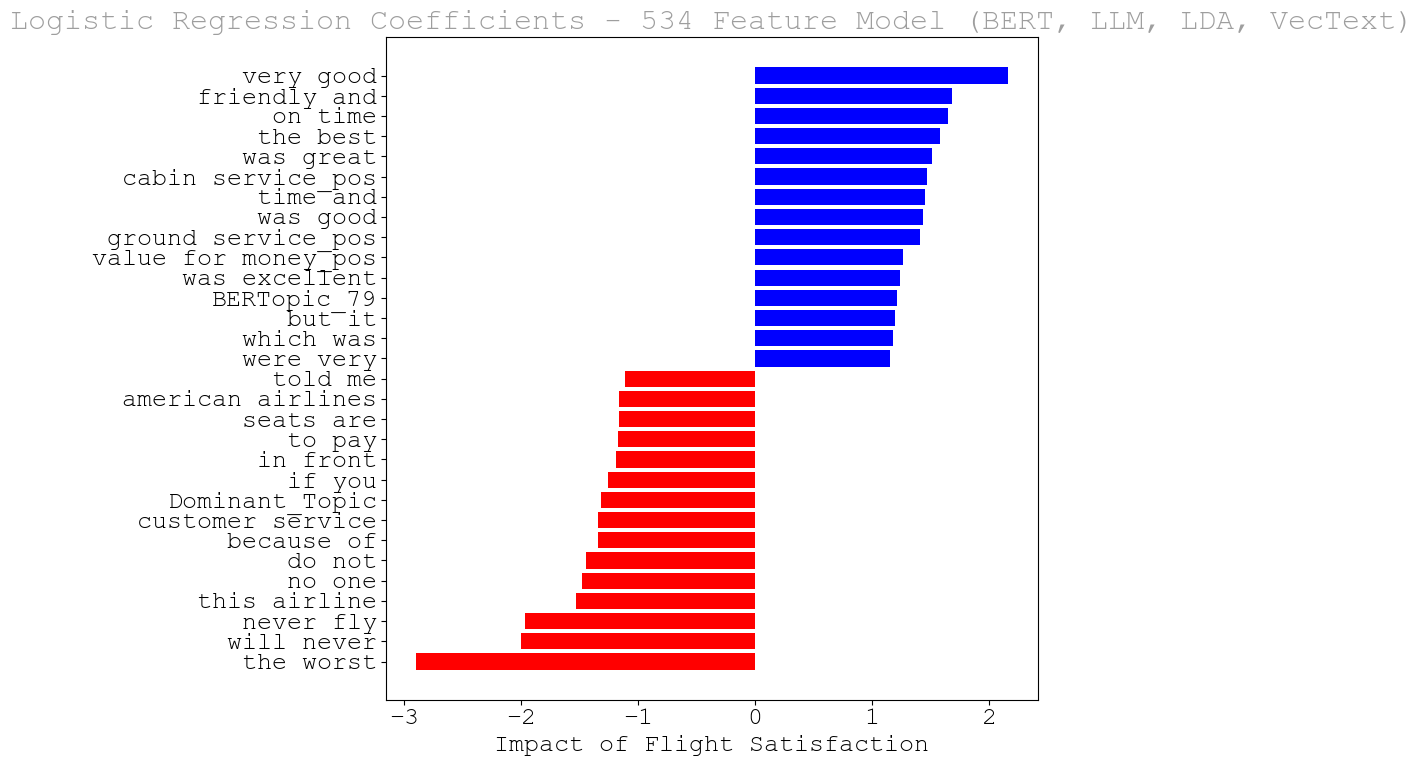

In [ ]:
# Separate positive and negative coefficients
positive_coef = coef_table[coef_table['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(15)
negative_coef = coef_table[coef_table['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(15)

# Combine them back
top_coef = pd.concat([negative_coef, positive_coef]).sort_values(by='Coefficient', ascending=True)

# Create colors array for the selected coefficients: red for negative, blue for positive
colors = ['red' if x < 0 else 'blue' for x in top_coef['Coefficient']]

# Plotting
plt.figure(figsize=(10, 8))  # Set figure size
plt.barh(top_coef['Variable'], top_coef['Coefficient'], color=colors)
plt.xlabel('Impact of Flight Satisfaction')
plt.title('Logistic Regression Coefficients - 534 Feature Model (BERT, LLM, LDA, VecText)')

# Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

### Big Model

As you can see, these features are simply not as useful.